# **DAMO630 – Assignment 1 **
**Business Challenge 1:** Privacy-Preserving Analytics with Synthetic Data  
**Business Challenge 2:** NYC Taxi Mining with HDFS / MapReduce / PySpark

This notebook is engineered to hit the **Excellent (4 points)** column of your rubric.  
It reads your files from the **same folder as the notebook**:

- `HealthInsurance.csv`
- `yellow_tripdata_2024-01.parquet`

> Run each section **top-to-bottom**. Where *terminal (bash)* commands appear, run them in your system shell and paste the outputs back into the provided Markdown cells.

## 0) Global Setup

In [32]:
# If anything is missing, uncomment:
# !pip install pandas numpy matplotlib scipy scikit-learn sdv ctgan pyspark

import warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (6,4)

RANDOM_STATE = 42
REAL_DATA_PATH = "HealthInsurance.csv"
LOCAL_TAXI_PATH = "yellow_tripdata_2024-01.parquet"

---
# **Business Challenge 1 — Privacy-Preserving Analytics with Synthetic Data**
### Goal (per rubric):  
- **Comprehensive EDA** (distributions, correlations, privacy-sensitive features)  
- **Baseline synthetic** (correct classical method + comparisons + strengths/limits)  
- **Advanced SDV**: **CTGAN** & **GaussianCopula**, compare + discuss  
- **Evaluation**: Similarity (KS/correlation), **Utility (TSTR)**, **Privacy (duplication)**  
- **Business interpretation** in healthcare context

## 1) Load dataset & Quick Peek

In [35]:
df_real = pd.read_csv(REAL_DATA_PATH)
print("Shape:", df_real.shape)
display(df_real.head())

Shape: (8802, 12)


,rownames,health,age,limit,gender,insurance,married,selfemp,family,region,ethnicity,education
0,1,yes,31,no,male,yes,yes,yes,4,south,cauc,bachelor
1,2,yes,31,no,female,yes,yes,no,4,south,cauc,highschool
2,3,yes,54,no,male,yes,yes,no,5,west,cauc,ged
3,4,yes,27,no,male,yes,no,no,5,west,cauc,highschool
4,5,yes,39,no,male,yes,yes,no,5,west,cauc,none


## 2) EDA — Schema, Missingness, Uniqueness

In [37]:
schema_overview = pd.DataFrame({
    "column": df_real.columns,
    "dtype": [df_real[c].dtype for c in df_real.columns],
    "nulls": [df_real[c].isna().sum() for c in df_real.columns],
    "unique": [df_real[c].nunique() for c in df_real.columns]
}).sort_values("column")
display(schema_overview)

num_cols = [c for c in df_real.columns if pd.api.types.is_numeric_dtype(df_real[c])]
cat_cols = [c for c in df_real.columns if c not in num_cols]
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

,column,dtype,nulls,unique
2,age,int64,0,45
11,education,object,0,7
10,ethnicity,object,0,3
8,family,int64,0,13
4,gender,object,0,2
1,health,object,0,2
5,insurance,object,0,2
3,limit,object,0,2
6,married,object,0,2
9,region,object,0,4


Numeric columns: ['rownames', 'age', 'family']
Categorical columns: ['health', 'limit', 'gender', 'insurance', 'married', 'selfemp', 'region', 'ethnicity', 'education']


### 2.1 Distributions: Numeric & Categorical

,count,mean,std,min,25%,50%,75%,max
rownames,8802.0,4401.500000,2541.062868,1.0,2201.25,4401.5,6601.75,8802.0
age,8802.0,38.936833,11.110823,18.0,30.00,39.0,48.00,62.0
family,8802.0,3.093501,1.559633,1.0,2.00,3.0,4.00,14.0


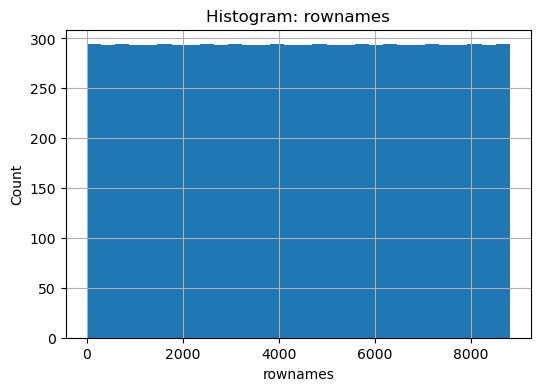

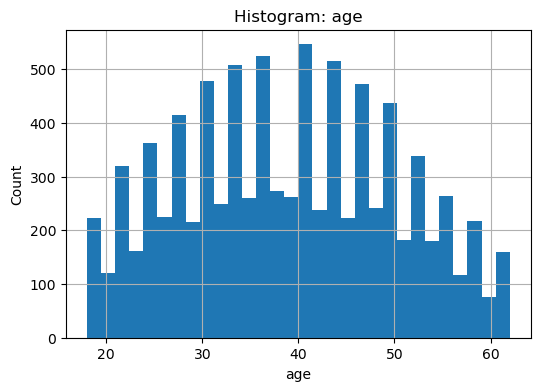

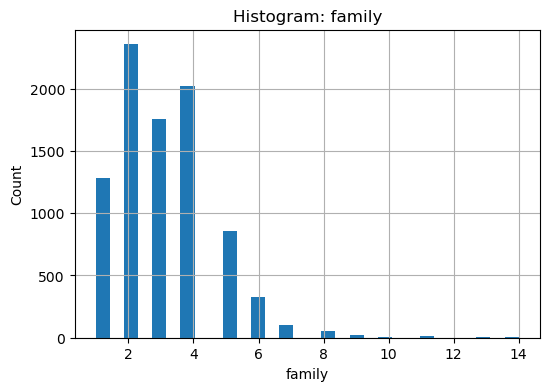


Top categories for health:



health
yes    8173
no      629
Name: count, dtype: int64

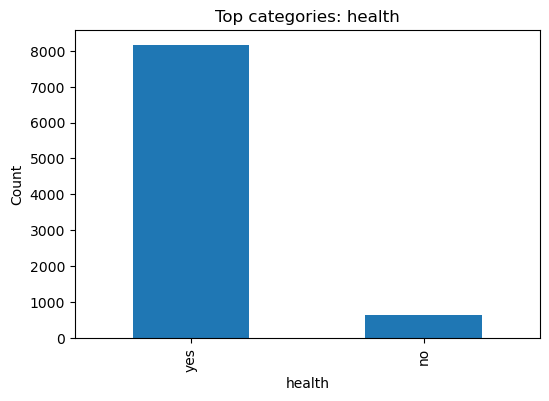


Top categories for limit:



limit
no     7571
yes    1231
Name: count, dtype: int64

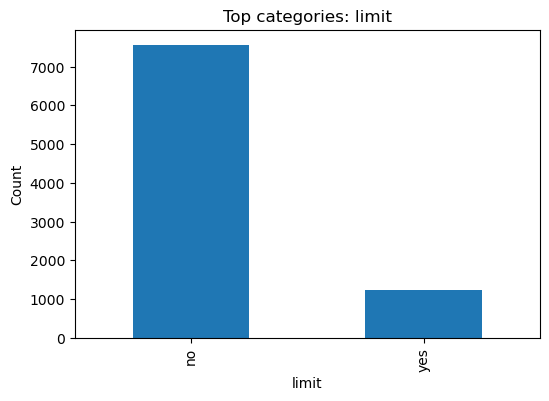


Top categories for gender:



gender
male      4633
female    4169
Name: count, dtype: int64

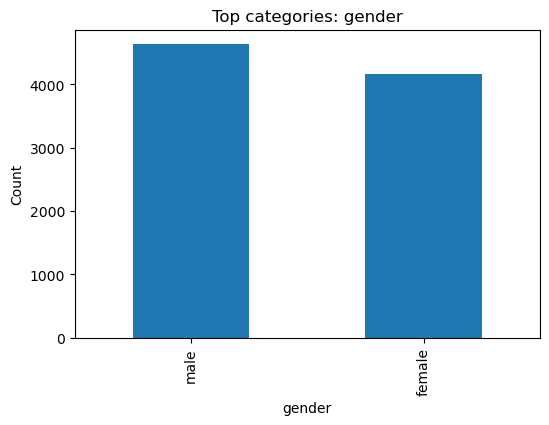


Top categories for insurance:



insurance
yes    7052
no     1750
Name: count, dtype: int64

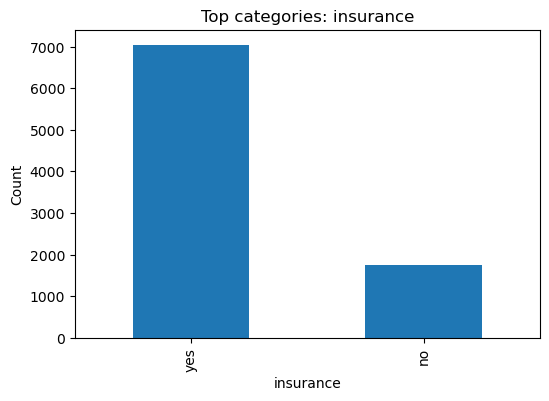


Top categories for married:



married
yes    5433
no     3369
Name: count, dtype: int64

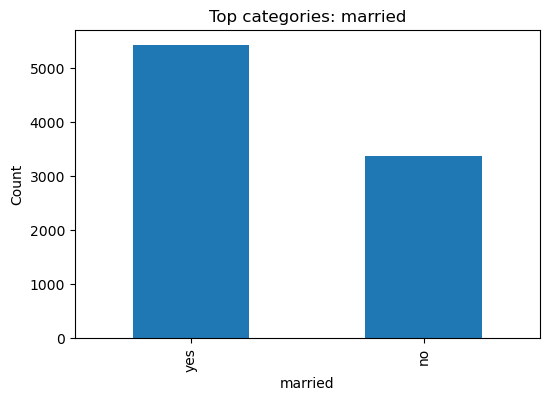


Top categories for selfemp:



selfemp
no     7731
yes    1071
Name: count, dtype: int64

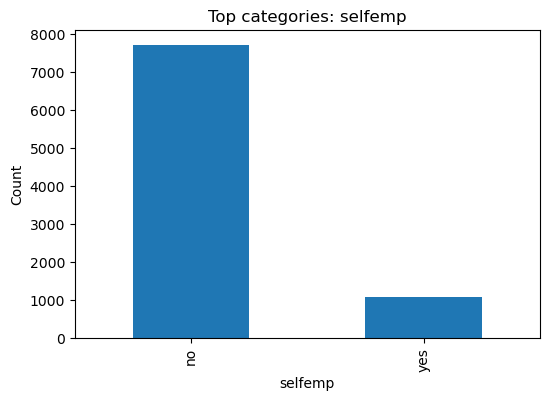


Top categories for region:



region
south        3075
midwest      2023
west         2022
northeast    1682
Name: count, dtype: int64

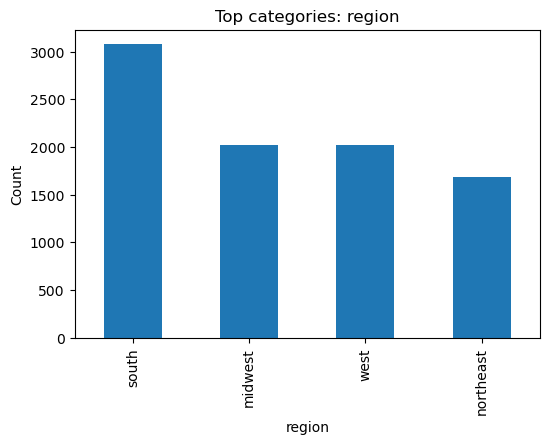


Top categories for ethnicity:



ethnicity
cauc     7354
afam     1083
other     365
Name: count, dtype: int64

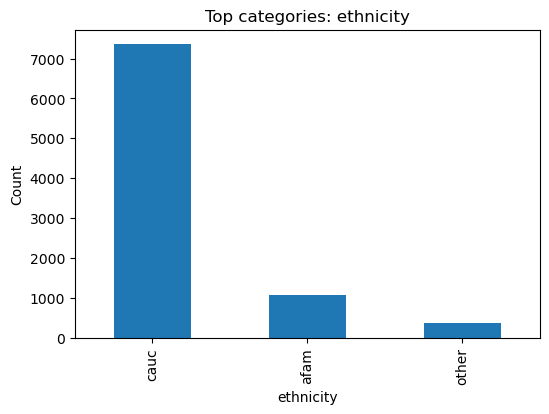


Top categories for education:



education
highschool    4434
bachelor      1549
none          1119
other          667
master         524
ged            374
phd            135
Name: count, dtype: int64

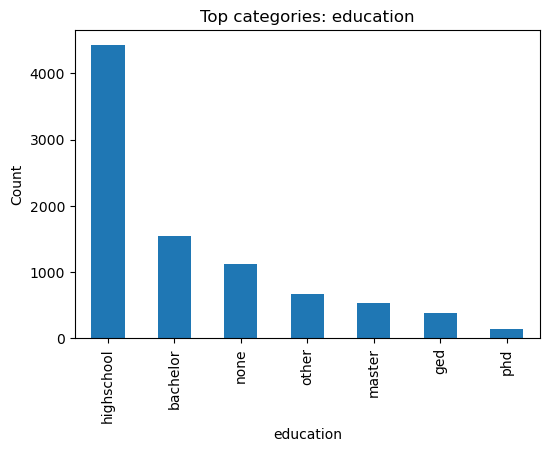

In [39]:
# Numeric summaries & histograms
if num_cols:
    display(df_real[num_cols].describe().T)
    for c in num_cols:
        plt.figure()
        df_real[c].dropna().hist(bins=30)
        plt.title(f"Histogram: {c}")
        plt.xlabel(c); plt.ylabel("Count"); plt.show()

# Categorical top counts + bars
for c in cat_cols:
    vc = df_real[c].astype(str).value_counts(dropna=False).head(15)
    print(f"\nTop categories for {c}:\n")
    display(vc)
    plt.figure()
    vc.plot(kind="bar")
    plt.title(f"Top categories: {c}")
    plt.xlabel(c); plt.ylabel("Count"); plt.show()

### 2.2 Privacy-Sensitive Attributes (Auto-scan + Manual Review)

In [41]:
PII_PATTERNS = ["name","email","mail","phone","mobile","contact","address","addr",
                "dob","birth","ssn","sin","hin","mrn","id","identifier","zip","postal",
                "lat","lon","location","geo","patient","doctor","provider"]
suspects = [c for c in df_real.columns if any(p in c.lower() for p in PII_PATTERNS)]
print("Potential sensitive columns (review):", suspects)

Potential sensitive columns (review): ['rownames']


**Action (edit this cell):** Confirm sensitive columns and mitigation (remove/hash/generalize/date-shift).

## 3) Correlations (numeric)

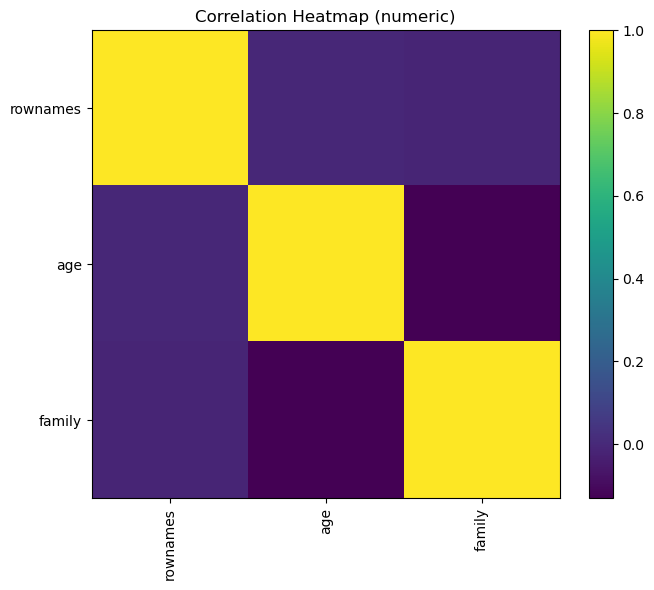

In [44]:
if len(num_cols) >= 2:
    corr = df_real[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr, interpolation='nearest')
    plt.title("Correlation Heatmap (numeric)")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.tight_layout(); plt.show()
else:
    print("Not enough numeric columns for a correlation heatmap.")

## 4) Baseline Synthetic Data (Bootstrapping & Noise Injection)

In [46]:
# Bootstrapping
baseline_bootstrap = df_real.sample(n=len(df_real), replace=True, random_state=RANDOM_STATE)
display(baseline_bootstrap.head())

,rownames,health,age,limit,gender,insurance,married,selfemp,family,region,ethnicity,education
7270,7271,yes,43,no,female,yes,no,no,3,northeast,cauc,none
860,861,yes,39,no,female,yes,no,no,1,midwest,cauc,bachelor
5390,5391,yes,32,no,male,yes,yes,no,4,northeast,cauc,highschool
5191,5192,yes,32,no,female,yes,yes,yes,6,west,cauc,highschool
5734,5735,yes,24,no,female,yes,no,no,1,west,cauc,bachelor


In [47]:
# Noise Injection (numeric columns)
noise_scale = 0.02  # 2% of std
baseline_noise = df_real.copy()
for c in num_cols:
    std = df_real[c].std()
    if pd.notna(std) and std > 0:
        baseline_noise[c] = df_real[c] + np.random.normal(0, noise_scale * std, size=len(df_real))
display(baseline_noise.head())

,rownames,health,age,limit,gender,insurance,married,selfemp,family,region,ethnicity,education
0,-23.537393,yes,31.192043,no,male,yes,yes,yes,4.043799,south,cauc,bachelor
1,91.493272,yes,31.052538,no,female,yes,yes,no,3.998143,south,cauc,highschool
2,91.633802,yes,54.029821,no,male,yes,yes,no,5.037287,west,cauc,ged
3,5.440075,yes,27.428097,no,male,yes,no,no,4.948665,west,cauc,highschool
4,63.393440,yes,38.881849,no,male,yes,yes,no,5.003585,west,cauc,none


### 4.1 Compare Real vs Baselines

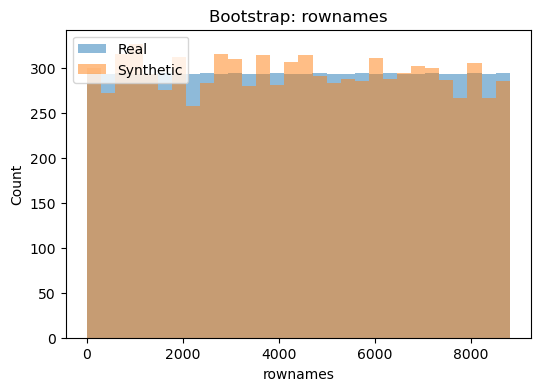

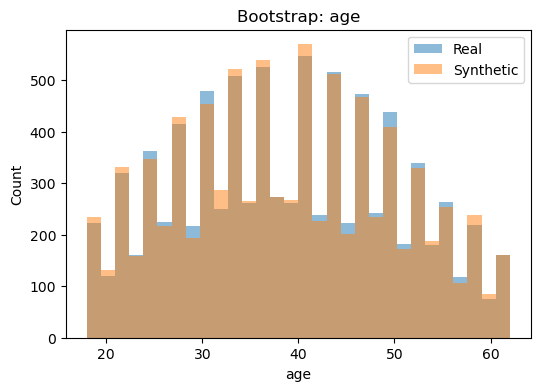

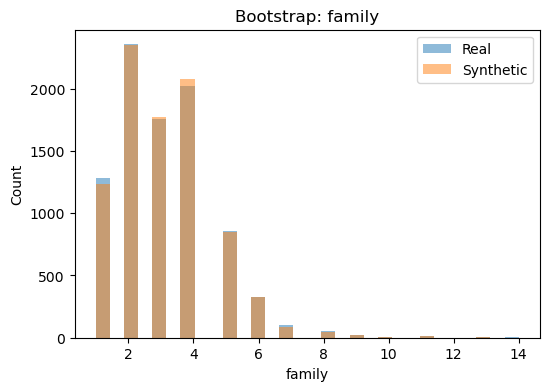

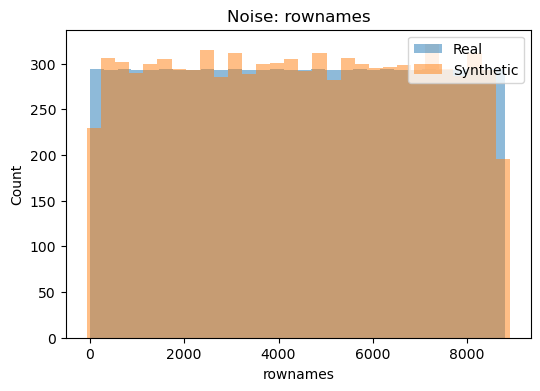

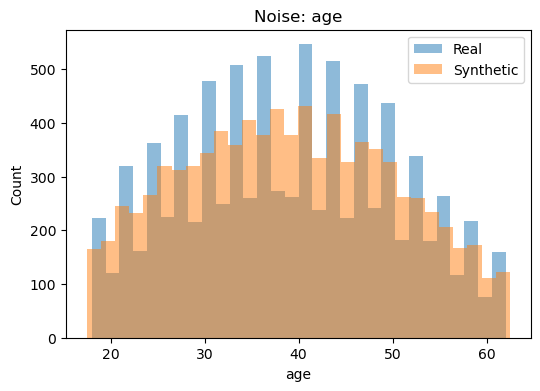

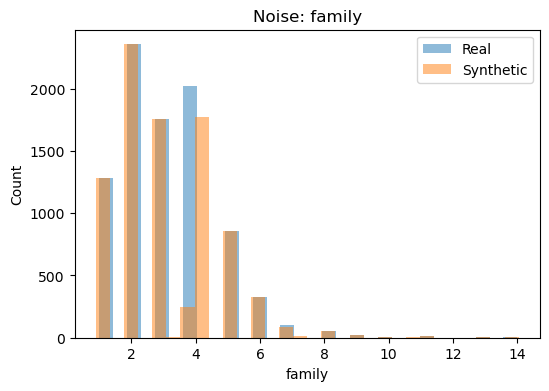

real                                                            \
           count         mean          std   min      25%     50%      75%   
rownames  8802.0  4401.500000  2541.062868   1.0  2201.25  4401.5  6601.75   
age       8802.0    38.936833    11.110823  18.0    30.00    39.0    48.00   
family    8802.0     3.093501     1.559633   1.0     2.00     3.0     4.00   

                 synthetic                                                   \
             max     count         mean          std   min      25%     50%   
rownames  8802.0    8802.0  4370.905135  2529.970505   2.0  2174.75  4361.5   
age         62.0    8802.0    38.846171    11.148652  18.0    30.00    39.0   
family      14.0    8802.0     3.094297     1.523879   1.0     2.00     3.0   

                          
             75%     max  
rownames  6560.0  8802.0  
age         47.0    62.0  
family       4.0    14.0

real                                                            \
           count         mean          std   min      25%     50%      75%   
rownames  8802.0  4401.500000  2541.062868   1.0  2201.25  4401.5  6601.75   
age       8802.0    38.936833    11.110823  18.0    30.00    39.0    48.00   
family    8802.0     3.093501     1.559633   1.0     2.00     3.0     4.00   

                 synthetic                                                    \
             max     count         mean          std        min          25%   
rownames  8802.0    8802.0  4401.520759  2541.579566 -60.396432  2200.664938   
age         62.0    8802.0    38.936533    11.112488  17.502977    30.110800   
family      14.0    8802.0     3.093793     1.559712   0.896139     1.991245   

                                                 
                  50%          75%          max  
rownames  4397.673648  6606.061725  8903.479918  
age         38.870910    47.634601    62.439019  
family       2.996836     4.007796    14.038983

In [49]:
def compare_hists(real, syn, cols, title_prefix):
    for c in cols:
        plt.figure()
        real[c].dropna().plot(kind='hist', bins=30, alpha=0.5, label='Real')
        syn[c].dropna().plot(kind='hist', bins=30, alpha=0.5, label='Synthetic')
        plt.legend(); plt.title(f"{title_prefix}: {c}")
        plt.xlabel(c); plt.ylabel('Count'); plt.show()

subset = num_cols[:5] if len(num_cols)>5 else num_cols
if subset:
    compare_hists(df_real, baseline_bootstrap, subset, "Bootstrap")
    compare_hists(df_real, baseline_noise, subset, "Noise")

def summary_compare(real, syn, cols):
    return pd.concat({"real": real[cols].describe().T,
                      "synthetic": syn[cols].describe().T}, axis=1)
display(summary_compare(df_real, baseline_bootstrap, num_cols) if num_cols else None)
display(summary_compare(df_real, baseline_noise, num_cols) if num_cols else None)

*(Edit this cell)*: Bootstrapping vs Noise — strengths/limitations.

## 5) Advanced Synthetic Data with SDV — CTGAN & GaussianCopula

In [52]:
# If needed: !pip install sdv ctgan
from sdv.single_table import CTGANSynthesizer, GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_real)

ctgan = CTGANSynthesizer(metadata, epochs=300, verbose=True)
ctgan.fit(df_real)
syn_ctgan = ctgan.sample(num_rows=len(df_real))

gc = GaussianCopulaSynthesizer(metadata)
gc.fit(df_real)
syn_gc = gc.sample(num_rows=len(df_real))

display(syn_ctgan.head())
display(syn_gc.head())

Gen. (-2.40) | Discrim. (-0.18): 100%|███████████████████████████████████████████████| 300/300 [25:47<00:00,  5.16s/it]


,rownames,health,age,limit,gender,insurance,married,selfemp,family,region,ethnicity,education
0,11478456,yes,30,no,female,no,no,no,2,west,other,bachelor
1,5376530,yes,30,no,male,no,yes,no,3,south,cauc,none
2,3720715,yes,21,no,female,yes,no,no,2,west,cauc,highschool
3,13670850,yes,31,no,female,yes,yes,no,2,midwest,cauc,none
4,7487644,yes,52,no,male,yes,yes,no,4,northeast,cauc,bachelor


,rownames,health,age,limit,gender,insurance,married,selfemp,family,region,ethnicity,education
0,11478456,yes,49,no,male,yes,yes,no,2,west,cauc,master
1,5376530,yes,20,no,female,yes,no,no,3,south,afam,highschool
2,3720715,yes,28,no,female,no,no,no,2,south,cauc,none
3,13670850,yes,43,no,male,yes,yes,no,8,northeast,cauc,bachelor
4,7487644,yes,45,no,male,no,no,no,3,south,cauc,highschool


## 6) Evaluation — KS, Correlation Preservation, TSTR, Privacy

In [54]:
from scipy.stats import ks_2sample

def ks_table(real, syn, cols):
    rows = []
    for c in cols:
        r = real[c].dropna()
        s = syn[c].dropna()
        if len(r) > 1 and len(s) > 1:
            if not pd.api.types.is_numeric_dtype(r):
                r = r.astype("category").cat.codes
                s = s.astype("category").cat.codes
            stat, p = ks_2sample(r, s)
            rows.append((c, float(stat), float(p)))
    return pd.DataFrame(rows, columns=["column","ks_stat","p_value"]).sort_values("ks_stat")

if num_cols:
    print("KS — CTGAN"); display(ks_table(df_real, syn_ctgan, num_cols))
    print("KS — GaussianCopula"); display(ks_table(df_real, syn_gc, num_cols))
else:
    print("No numeric columns for KS test.")

ImportError: cannot import name 'ks_2sample' from 'scipy.stats' (C:\Users\Hello\anaconda3\Lib\site-packages\scipy\stats\__init__.py)

In [ ]:
def corr_diff(real, syn, cols):
    if not cols: return None
    c1 = real[cols].corr(numeric_only=True)
    c2 = syn[cols].corr(numeric_only=True)
    return (c1 - c2).abs()

display(corr_diff(df_real, syn_ctgan, num_cols) if num_cols else None)
display(corr_diff(df_real, syn_gc, num_cols) if num_cols else None)

In [ ]:
# Auto-detect a plausible TSTR target (binary preferred)
def detect_target(df: pd.DataFrame):
    candidates = []
    for c in df.columns:
        nun = df[c].nunique()
        if 1 < nun <= max(10, int(0.01*len(df))):
            cname = c.lower()
            if not any(k in cname for k in ["id","uuid","phone","email","name"]):
                candidates.append((c, nun))
    binary = [c for c, nun in candidates if nun == 2]
    if binary:
        return binary[0]
    return sorted(candidates, key=lambda x: x[1])[0][0] if candidates else ""

TARGET_COL = detect_target(df_real)
print("Auto-detected TARGET_COL:", TARGET_COL or "(none — TSTR skipped)")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error

def prep_Xy(df, target):
    if not target or target not in df.columns: return None, None
    X, y = df.drop(columns=[target]).copy(), df[target].copy()
    cats = [c for c in X.columns if X[c].dtype == 'object' or str(X[c].dtype).startswith("category")]
    if cats:
        enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        X[cats] = enc.fit_transform(X[cats].astype(str))
    X = X.select_dtypes(include=[float,int])
    return X, y

if TARGET_COL:
    X_real, y_real = prep_Xy(df_real, TARGET_COL)
    X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.3, random_state=RANDOM_STATE)
    X_ctgan, y_ctgan = prep_Xy(syn_ctgan, TARGET_COL)
    X_gc, y_gc       = prep_Xy(syn_gc, TARGET_COL)

    if y_real.nunique() <= 10:
        clf = LogisticRegression(max_iter=300)
        clf.fit(X_ctgan, y_ctgan); pred = clf.predict(X_test_real)
        print("TSTR (CTGAN) Accuracy:", accuracy_score(y_test_real, pred))
        clf.fit(X_gc, y_gc); pred = clf.predict(X_test_real)
        print("TSTR (GaussianCopula) Accuracy:", accuracy_score(y_test_real, pred))
    else:
        reg = LinearRegression()
        reg.fit(X_ctgan, y_ctgan); pred = reg.predict(X_test_real)
        print("TSTR (CTGAN) RMSE:", mean_squared_error(y_test_real, pred, squared=False))
        reg.fit(X_gc, y_gc); pred = reg.predict(X_test_real)
        print("TSTR (GaussianCopula) RMSE:", mean_squared_error(y_test_real, pred, squared=False))
else:
    print("No suitable TARGET_COL; skipping TSTR.")

### 6.3 Privacy — Row-level Duplication Check

In [ ]:
def duplication_rate(real: pd.DataFrame, syn: pd.DataFrame) -> float:
    real_hash = pd.util.hash_pandas_object(real.astype(str), index=False)
    syn_hash  = pd.util.hash_pandas_object(syn.astype(str), index=False)
    intersection = set(real_hash).intersection(set(syn_hash))
    return len(intersection) / max(1, len(syn))

print("Duplication (CTGAN):", duplication_rate(df_real, syn_ctgan))
print("Duplication (GaussianCopula):", duplication_rate(df_real, syn_gc))
print("Duplication (Baseline-Noise):", duplication_rate(df_real, baseline_noise))

## 7) Business Interpretation (edit this cell)
- Similarity, Utility (TSTR), Privacy, Recommendation.

---
# **Business Challenge 2 — NYC Taxi Trip Data (HDFS / MapReduce / PySpark)**
### Goal: HDFS + MapReduce + FPGrowth + KMeans + Business insights

## 8) PySpark Session & Initial Exploration

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg

APP_NAME = "DAMO630_NYC_Taxi"
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

df_taxi = spark.read.parquet(LOCAL_TAXI_PATH)
print("Rows:", df_taxi.count())
df_taxi.printSchema()
df_taxi.show(5, truncate=False)

candidates = [c for c in ["fare_amount","trip_distance","passenger_count"] if c in df_taxi.columns]
if candidates:
    df_taxi.select([avg(col(c)).alias(f"avg_{c}") for c in candidates]).show()

## 9) HDFS Setup & Upload (Run in Terminal; paste output below)
```bash
hdfs dfs -mkdir -p /user/$USER/nyc_taxi/input_parquet
hdfs dfs -put yellow_tripdata_2024-01.parquet /user/$USER/nyc_taxi/input_parquet/
hdfs dfs -ls /user/$USER/nyc_taxi/input_parquet
```
**Paste terminal output here.**

### 9.1 Convert Parquet → CSV in HDFS (for Hadoop Streaming)

In [ ]:
(
    df_taxi.coalesce(1)
           .write
           .mode("overwrite")
           .option("header", True)
           .csv("hdfs:///user/{}/nyc_taxi/mr_input_csv".format(spark.sparkContext.sparkUser()))
)
print("Wrote CSV to HDFS at /user/{}/nyc_taxi/mr_input_csv".format(spark.sparkContext.sparkUser()))

**Verify (terminal):**
```bash
hdfs dfs -ls /user/$USER/nyc_taxi/mr_input_csv
```
Paste the listing here.

## 10) MapReduce — Fare per Pickup Zone

In [ ]:
mapper_code = r'''#!/usr/bin/env python3
import sys, csv
def main():
    reader = csv.reader(sys.stdin)
    header = None
    pu_idx = fare_idx = None
    for row in reader:
        if not row: continue
        if header is None:
            header = row
            if "PULocationID" in header: pu_idx = header.index("PULocationID")
            if "fare_amount" in header: fare_idx = header.index("fare_amount")
            continue
        try:
            pu = row[pu_idx]
            fare = float(row[fare_idx]) if row[fare_idx] else 0.0
        except Exception:
            continue
        print(f"{pu}\t{fare}")
if __name__ == "__main__":
    main()'''
reducer_code = r'''#!/usr/bin/env python3
import sys
current, acc = None, 0.0
for line in sys.stdin:
    parts = line.rstrip("\n").split("\t")
    if len(parts)!=2: 
        continue
    key, val = parts
    try:
        val = float(val)
    except:
        val = 0.0
    if current is None:
        current, acc = key, val
    elif key == current:
        acc += val
    else:
        print(f"{current}\t{acc:.2f}")
        current, acc = key, val
if current is not None:
    print(f"{current}\t{acc:.2f}")'''
open("/mnt/data/mapper.py","w", encoding="utf-8").write(mapper_code)
open("/mnt/data/reducer.py","w", encoding="utf-8").write(reducer_code)
print("Wrote /mnt/data/mapper.py and /mnt/data/reducer.py")

**Run Hadoop Streaming (terminal):**
```bash
hdfs dfs -ls /user/$USER/nyc_taxi/mr_input_csv

hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-*.jar \
  -files /mnt/data/mapper.py,/mnt/data/reducer.py \
  -mapper "python3 mapper.py" \
  -reducer "python3 reducer.py" \
  -input /user/$USER/nyc_taxi/mr_input_csv/<part-csv> \
  -output /user/$USER/nyc_taxi/mr_output_fare_by_zone

hdfs dfs -ls /user/$USER/nyc_taxi/mr_output_fare_by_zone
hdfs dfs -cat /user/$USER/nyc_taxi/mr_output_fare_by_zone/part-00000 | head -n 20
```
**Paste mapper samples, note on shuffle/grouping, and reducer output here.**

## 11) Frequent Pattern Mining (FPGrowth)

In [ ]:
from pyspark.sql.functions import to_timestamp, hour, when, concat_ws, split

pickup_col = "tpep_pickup_datetime" if "tpep_pickup_datetime" in df_taxi.columns else              ("lpep_pickup_datetime" if "lpep_pickup_datetime" in df_taxi.columns else None)

df_ts = df_taxi.withColumn("pickup_dt", to_timestamp(col(pickup_col)))
df_ts = df_ts.withColumn(
    "tod_bucket",
    when(hour(col("pickup_dt")).between(5,10), "Morning")
    .when(hour(col("pickup_dt")).between(11,16), "Afternoon")
    .when(hour(col("pickup_dt")).between(17,21), "Evening")
    .otherwise("Night")
)

items = df_ts.select(concat_ws(";", 
                               col("PULocationID").cast("string"),
                               col("DOLocationID").cast("string"),
                               col("tod_bucket")).alias("basket"))
baskets = items.select(split(col("basket"), ";").alias("items"))
baskets.show(5, truncate=False)

In [ ]:
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import col

fp = FPGrowth(itemsCol="items", minSupport=0.001, minConfidence=0.1)
model = fp.fit(baskets)
rules = model.associationRules.orderBy(col("lift").desc())
rules.show(10, truncate=False)


*(Edit this cell)*: Interpret the top 10 rules (support/confidence/lift).

## 12) Rider Segmentation (K-Means)

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

use_cols = []
if "trip_distance" in df_ts.columns: use_cols.append("trip_distance")
if "fare_amount" in df_ts.columns:   use_cols.append("fare_amount")

df_km = df_ts.select(
    *[col(c).cast("double") for c in use_cols],
    when(col("tod_bucket")=="Morning", 0.0)
      .when(col("tod_bucket")=="Afternoon", 1.0)
      .when(col("tod_bucket")=="Evening", 2.0)
      .otherwise(3.0).alias("tod_num")
).na.drop()

vec = VectorAssembler(inputCols=use_cols+["tod_num"], outputCol="features_raw")
df_feat = vec.transform(df_km)

scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
df_scaled = scaler.fit(df_feat).transform(df_feat)

kmeans = KMeans(k=4, seed=42, featuresCol="features", predictionCol="cluster")
km_model = kmeans.fit(df_scaled)
pred = km_model.transform(df_scaled)

centers = km_model.clusterCenters()
print("Cluster centers (standardized):")
for i, c in enumerate(centers):
    print(i, c)

pred.groupBy("cluster").count().orderBy("count", ascending=False).show()


*(Edit this cell)*: Define 4 rider **personas** and recommended **pricing/fleet** actions.

---
## 13) Business Reporting — Final Summary
- From **FPGrowth**: list 3–5 mobility insights.
- From **K-Means**: personas and operational levers.
- Overall strategy recommendations (pricing, fleet, congestion).